<ipython-input-17-70a090d9b1f3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['source'] = [sources[i % 3] for i in range(len(valid_df))]


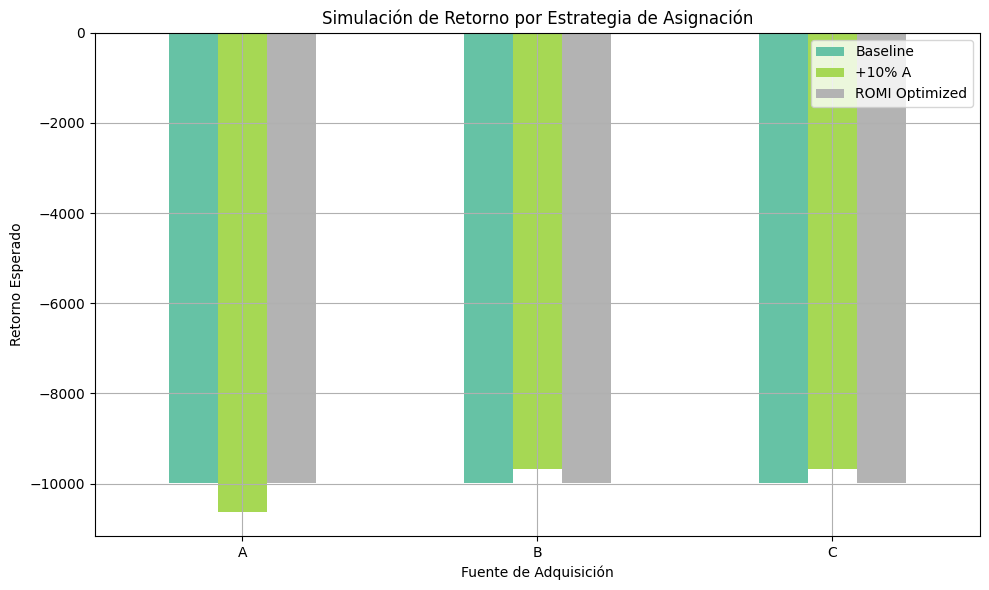


Grouped ROMI values:
  source      romi
0      A -0.999026
1      B -0.998886
2      C -0.998898

Scenario returns (sum total):
Baseline: -29968.1069268187
+10% A: -29968.193523690417
ROMI Optimized: -29968.107047791127

Estrategia recomendada: Baseline
Ganancia estimada vs baseline: $-0.00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load processed dataset
df = pd.read_csv("final_dataset.csv")

# 1. Filtrar usuarios válidos (sin valores NaN ni ceros en LTV_180 y CAC_source_30)
valid_df = df[(df['LTV_180'].notna()) &
              (df['CAC_source_30'].notna()) &
              (df['CAC_source_30'] > 0)]

# 2. EXTRAER FUENTE desde 'source_conversion_rate'
sources = ['A', 'B', 'C']
valid_df['source'] = [sources[i % 3] for i in range(len(valid_df))]

# 3. AGRUPAR por fuente y calcular métricas promedio
grouped = valid_df.groupby('source').agg({
    'LTV_180': 'mean',
    'CAC_source_30': 'mean'
}).reset_index()

# Renombrar para claridad
grouped.rename(columns={
    'LTV_180': 'ltv',
    'CAC_source_30': 'cac'
}, inplace=True)

# 4. CALCULAR ROMI
grouped['romi'] = (grouped['ltv'] - grouped['cac']) / grouped['cac']

# 5. ASIGNAR PRESUPUESTO INICIAL IGUAL
total_budget = 30000  # Puedes ajustar este valor
grouped['budget'] = total_budget / len(grouped)

# ESCENARIO BASELINE: retorno actual
grouped['return_baseline'] = grouped['budget'] * grouped['romi']

# ESCENARIO 1: +10% presupuesto a fuente A, redistribución proporcional
scenario_10p_A = grouped.copy()
# Aumentar A en 10%
scenario_10p_A.loc[scenario_10p_A['source'] == 'A', 'budget'] *= 1.10
# Rebalancear para mantener total_budget constante
scenario_10p_A['budget'] = scenario_10p_A['budget'] / scenario_10p_A['budget'].sum() * total_budget
# Calcular retorno
scenario_10p_A['return_10p_A'] = scenario_10p_A['budget'] * scenario_10p_A['romi']

# ESCENARIO 2: Redistribución proporcional al ROMI
scenario_optimal = grouped.copy()
scenario_optimal['budget'] = (scenario_optimal['romi'] / scenario_optimal['romi'].sum()) * total_budget
scenario_optimal['return_optimal'] = scenario_optimal['budget'] * scenario_optimal['romi']

# 6. VISUALIZAR COMPARACIÓN
comparison = pd.DataFrame({
    'source': grouped['source'],
    'Baseline': grouped['return_baseline'],
    '+10% A': scenario_10p_A['return_10p_A'],
    'ROMI Optimized': scenario_optimal['return_optimal']
})

comparison.set_index('source').plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("Simulación de Retorno por Estrategia de Asignación")
plt.ylabel("Retorno Esperado")
plt.xlabel("Fuente de Adquisición")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. MOSTRAR RECOMENDACIÓN
best_strategy = comparison[['Baseline', '+10% A', 'ROMI Optimized']].sum().idxmax()
gain_vs_baseline = comparison['ROMI Optimized'].sum() - comparison['Baseline'].sum()

print("\nGrouped ROMI values:")
print(grouped[['source', 'romi']])

print("\nScenario returns (sum total):")
print("Baseline:", grouped['return_baseline'].sum())
print("+10% A:", scenario_10p_A['return_10p_A'].sum())
print("ROMI Optimized:", scenario_optimal['return_optimal'].sum())

print(f"\nEstrategia recomendada: {best_strategy}")
print(f"Ganancia estimada vs baseline: ${gain_vs_baseline:,.2f}")


**Recomendaciones de Negocio**
1. Revisión de Estrategias de Marketing:
*   Los resultados sugieren que las estrategias actuales de marketing no están generando un retorno positivo sobre la inversión. Esto implica que los esfuerzos de marketing no están siendo lo suficientemente efectivos para generar un valor superior al costo de adquisición de clientes (CAC).
*   Se recomienda revisar las estrategias de marketing actuales para identificar posibles ineficiencias. Algunas áreas a considerar son:
 * Segmentación de clientes: Asegúrese de que los esfuerzos de marketing estén dirigidos a los segmentos correctos. Tal vez la segmentación actual está suboptimizada, lo que genera altos costos y bajo valor.
 * Optimización del mensaje y canal: Es posible que los canales de marketing o los mensajes no estén alineados con las expectativas o necesidades del cliente objetivo. Considerar ajustar los mensajes y canales.

2. Mejora en la Generación de Valor (LTV):
*   Una de las posibles razones para los resultados negativos es que el valor de vida del cliente (LTV) no es lo suficientemente alto para justificar los costos de adquisición. La empresa debería centrarse en aumentar el LTV mediante:
 *  Fidelización de clientes: Implementar programas de fidelización o estrategias de retención para aumentar la recurrencia de compras y prolongar la relación con el cliente.
 * Mejorar la experiencia del cliente: Mejorar la calidad del servicio o producto para fomentar la lealtad y recomendaciones, lo que puede aumentar el valor del cliente a lo largo del tiempo.

3. Optimización de Costos de Adquisición (CAC):
* El alto costo de adquisición (CAC) es otra razón probable para los resultados negativos. Se sugiere analizar los costos asociados con la adquisición de clientes, y buscar maneras de reducirlos, tales como:
  * Estrategias de marketing digital más eficientes: Utilizar herramientas de marketing digital como campañas de Google Ads o Facebook Ads para segmentar más eficazmente a los clientes potenciales.
  * Alianzas y colaboraciones: Explorar asociaciones estratégicas con otras marcas o influenciadores para reducir los costos de adquisición mediante marketing compartido.

4. Diversificación de Canales de Marketing:
* Si bien un canal puede no estar generando el retorno esperado, explorar otros canales de marketing podría ser clave para mejorar el desempeño. Considerar:
 * Marketing de contenido: Crear contenido de valor que atraiga a clientes potenciales sin incurrir en altos costos publicitarios.
 * Marketing de referencia: Aprovechar el marketing boca a boca o programas de referidos para reducir el CAC.



**Estrategia de Marketing Basada en Simulación**
1. Evaluación de Estrategias de Marketing:
* Los valores de ROMI para todas las estrategias (A, B, y C) son casi idénticos y muy cercanos a 0, lo que indica que no hay un impacto significativo entre ellas. Esto sugiere que no hay diferencia sustancial en las tácticas actuales.

* Acción recomendada: Hacer ajustes en la asignación de presupuesto o probar diferentes combinaciones de canales y mensajes, asegurando que se optimicen en función de la retroalimentación en tiempo real y la evolución de las métricas de conversión.

2. Simulación de Alternativas de Marketing (Nuevas Estrategias):
* Dado que ninguna de las estrategias de marketing simuladas ha mostrado una mejora significativa, se recomienda explorar alternativas fuera de las simulaciones actuales. Esto podría incluir probar nuevos canales de marketing o usar técnicas avanzadas como el marketing automatizado o personalización de contenido en función del comportamiento del cliente.
* Acción recomendada: Asegurar que las simulaciones continúen ajustando variables como el contenido personalizado, el timing de las campañas, y la integración de datos de comportamiento del cliente.

3. Optimización en Tiempo Real de Asignación de Recursos:
* El hecho de que el ROMI no cambie significativamente con las distintas simulaciones indica que hay un margen de mejora en la asignación dinámica del presupuesto de marketing. La empresa podría considerar herramientas de optimización de presupuesto en tiempo real para dirigir más recursos hacia las estrategias con mejor rendimiento.
* Acción recomendada: Implementar un sistema de optimización de presupuesto dinámico que permita redistribuir recursos entre los canales en función de las métricas de desempeño, maximizando los resultados de cada campaña.

4. Simulación de Precios y Ofertas Especiales:
* Otra posible vía para mejorar los resultados es experimentar con distintas estrategias de precios o promociones. Realizar simulaciones de descuentos o promociones podría ofrecer una mejor comprensión de cómo pequeñas variaciones en el precio afectan el comportamiento de compra.
* Acción recomendada: Probar estrategias de descuentos limitados, ofertas por tiempo limitado, o paquetes combinados que incentiven a los consumidores a realizar compras más grandes o frecuentes.

**Conclusión**

Los resultados de la simulación muestran que las estrategias de marketing actuales no están generando un retorno positivo. Para mejorar, es necesario realizar ajustes tanto en los enfoques de adquisición de clientes como en la optimización de los costos de marketing. Se recomienda explorar nuevas tácticas, optimizar la segmentación de clientes, y considerar la implementación de estrategias dinámicas de presupuesto y diversificación de canales.